In [1]:
from stable_baselines3 import DQN, A2C
from stable_baselines3.dqn.policies import CnnPolicy
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy

import gym
import os

import numpy as np
import torch
import matplotlib.pyplot as plt

# Choose environment and load already trained agent

In [2]:
# env_name = 'MsPacmanNoFrameskip-v4'
# env_name = 'BreakoutNoFrameskip-v4'
env_name = 'PongNoFrameskip-v4'
env = make_atari_env(env_name, n_envs=1, seed=0)
# Stack 4 frames
env = VecFrameStack(env, n_stack=4)

model = DQN.load('models/PongNoFrameskip-V4')
model.set_env(env)

# Callbacks

In [5]:
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from tqdm.auto import tqdm
    

class ProgressBarCallback(BaseCallback):
    """
    :param pbar: (tqdm.pbar) Progress bar object
    """
    def __init__(self, pbar):
        super(ProgressBarCallback, self).__init__()
        self._pbar = pbar

    def _on_step(self):
        # Update the progress bar:
        self._pbar.n = self.num_timesteps
        self._pbar.update(0)

# this callback uses the 'with' block, allowing for correct initialisation and destruction
class ProgressBarManager(object):
    def __init__(self, total_timesteps): # init object with total timesteps
        self.pbar = None
        self.total_timesteps = total_timesteps
        
    def __enter__(self): # create the progress bar and callback, return the callback
        self.pbar = tqdm(total=self.total_timesteps)
            
        return ProgressBarCallback(self.pbar)

    def __exit__(self, exc_type, exc_val, exc_tb): # close the callback
        self.pbar.n = self.total_timesteps
        self.pbar.update(0)
        self.pbar.close()

# Collect trajectories

In [8]:
timesteps = 2000
with ProgressBarManager(timesteps) as pbar_callback:
    model.learn(timesteps, callback=pbar_callback)

  0%|          | 0/2000 [00:00<?, ?it/s]

# Evaluate agent

In [156]:
# Use a separate environement for evaluation
env = make_atari_env(env_name, n_envs=1, seed=0)
# Stack 4 frames
env = VecFrameStack(env, n_stack=4)

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:21.00 +/- 0.00


In [20]:
model.policy

CnnPolicy(
  (q_net): QNetwork(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): Flatten(start_dim=1, end_dim=-1)
      )
      (linear): Sequential(
        (0): Linear(in_features=3136, out_features=512, bias=True)
        (1): ReLU()
      )
    )
    (q_net): Sequential(
      (0): Linear(in_features=512, out_features=4, bias=True)
    )
  )
  (q_net_target): QNetwork(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): Flatten(start_dim=1, end_di

# Display working agent in the environemnt

In [53]:
env = make_atari_env(env_name, n_envs=1, seed=0)
# Stack 4 frames
env = VecFrameStack(env, n_stack=4)

obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()

KeyboardInterrupt: 

In [9]:
X = torch.Tensor(model.replay_buffer.observations)

In [10]:
net = model.q_net
net.eval()

QNetwork(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (q_net): Sequential(
    (0): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [182]:
gym.make(env_name).unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [109]:
def display_attributions_for_example(idx,
                                    X,
                                    net,
                                    ):

    img = X[idx]

    target = int(net.predict(X[idx].cpu().detach().numpy())[0][0])
    print(net.forward(img).cpu().detach().numpy()[0])
    # img.requires_grad = True
    ig = IntegratedGradients(net)

    # ig.attribute(input, target=labels[ind])
    attr_ig, delta = ig.attribute(img, n_steps=200, target=target, baselines=img * 0, return_convergence_delta=True)
    if target in [2, 4]:
        print('Action: UP')
    if target in [3, 5]:
        print('Action: DOWN')
    if target in [0, 1]:
        print('Action: STAY')

    # attr_ig, delta = attribute_image_features(ig, img, baselines=img * 0, return_convergence_delta=True)
    # attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (0, 1))
    print('Approximation delta: ', abs(delta))

    frames = []
    img_ = np.transpose(img.squeeze().cpu().detach().numpy(), (1, 2, 0))
    attr_ig_ = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))

    for i in range(4, 0, -1):
        frames.append((img_[:, :, -(i)].reshape(84, 84, 1),
                        attr_ig_[:, :, -(i)].reshape(84, 84, 1)))

    for frame in frames:
        _ = viz.visualize_image_attr_multiple(frame[1],
                                              frame[0],
                                              ["original_image", "blended_heat_map"],
                                              ["all", "positive"],
                                              show_colorbar=True,
                                              titles=['Original image', 'Integrated gradients positive attributions'],
                                              fig_size=(8, 6)
                                             )

# Interpret action before hitting the ball

[1.1901281 1.1890688 1.1877968 1.1958792 1.1888899 1.1959704]
Action: DOWN
Approximation delta:  tensor([0.0008], dtype=torch.float64)


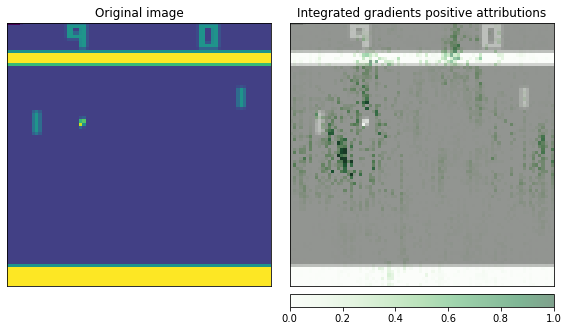

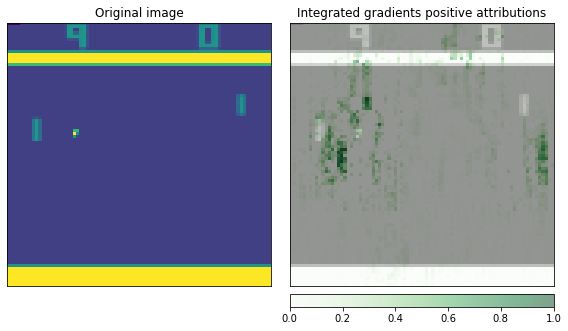

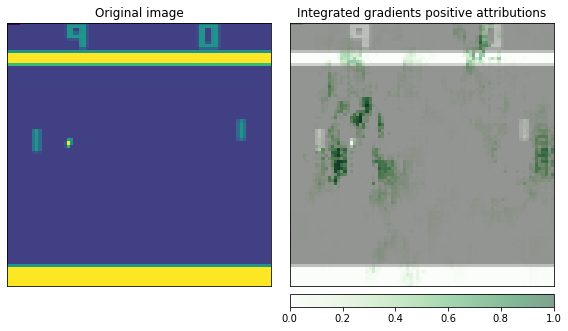

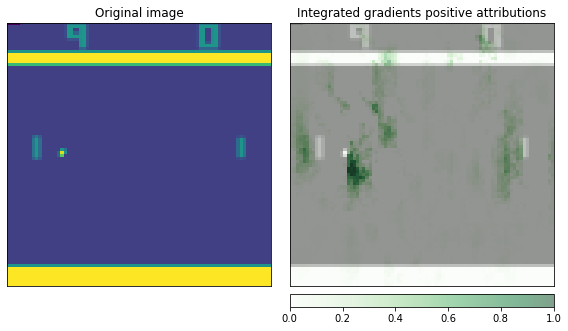

In [110]:
display_attributions_for_example(idx=459,
                                X=X,
                                net=net)

# Interpret action during and after hitting the ball

[1.2547958 1.2516996 1.2497804 1.2598968 1.2684479 1.2650523]
Action: UP
Approximation delta:  tensor([0.0051], dtype=torch.float64)


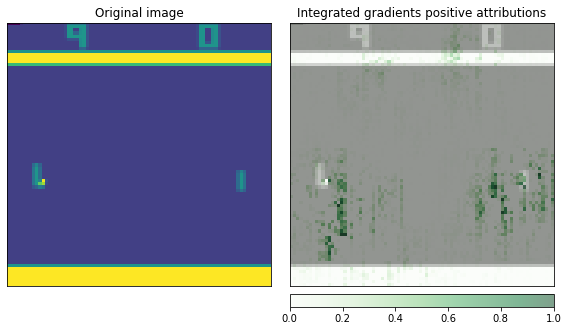

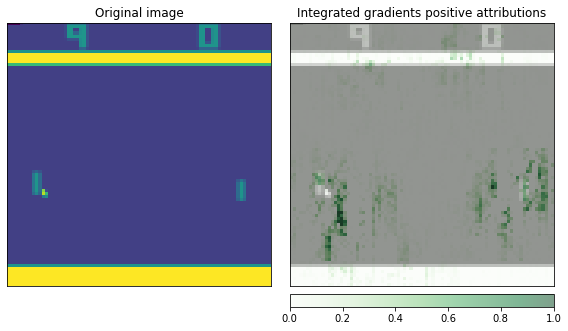

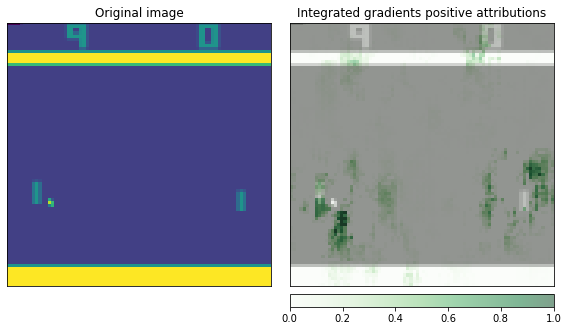

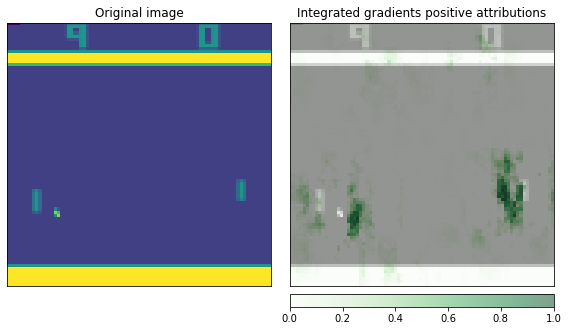

In [111]:
display_attributions_for_example(idx=465,
                                X=X,
                                net=net)